## Import Packages

In [ ]:
# Import sodapy and other packages
!pip install sodapy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import seaborn as sns
import sodapy as spy
from sklearn.metrics import classification_report, confusion_matrix

## Virginal OpenData Portal and the Socrata API
The following Python program will retrieve some data from the VA Open Data Portal CY2021 Maternal and Child Health Focus

In [ ]:
# Create Socrata client
data_url = "data.virginia.gov"
data_set = "b6ux-y6yi"
client = spy.Socrata(data_url, app_token= "wEiZLz2RwQ5niCoBwXyFIptzm",
                     timeout=50)
results = client.get(data_set)

## Store as Dataframe

In [ ]:
# Convert the list of dictionaries into a dataframe
maternity_data = pd.DataFrame.from_records(results)
# See unique values of out target
maternity_data["gestational_age"].unique()
# Recode the variable to at risk if it is before Early Term
maternity_data["gestional_age_risk"] = np.select([maternity_data["gestational_age"].isin(['Early Term', 'Full Term', 'Late Term']),
                                                    maternity_data["gestational_age"].isin(['Late Preterm', 'Very Preterm',
       'Extremely Preterm', 'Post Term', 'Moderate Preterm'])]
                                                    , [0, 1])

In [ ]:
#maternity data columns
maternity_data.columns

Index(['singleton', 'medicaid_program', 'population_group', 'delivery_system',
       'mco_count', 'cont_enroll_category', 'gravidity', 'trimester',
       'maternal_region', 'maternal_raceeth', 'maternal_age',
       'maternal_asthma', 'maternal_diabetes', 'gestational_diabetes',
       'pnc_index', 'gestational_age', 'birth_weight', 'delivery_method',
       'ed_utilization', 'amb_utilization', 'prenatal_sbirt',
       'postpartum_sbirt', 'prenatal_depscr', 'postpartum_depscr',
       'gestional_age_risk'],
      dtype='object')

In [ ]:
#maternity data info
maternity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   singleton             1000 non-null   object
 1   medicaid_program      1000 non-null   object
 2   population_group      1000 non-null   object
 3   delivery_system       1000 non-null   object
 4   mco_count             1000 non-null   object
 5   cont_enroll_category  1000 non-null   object
 6   gravidity             1000 non-null   object
 7   trimester             1000 non-null   object
 8   maternal_region       1000 non-null   object
 9   maternal_raceeth      1000 non-null   object
 10  maternal_age          1000 non-null   object
 11  maternal_asthma       1000 non-null   object
 12  maternal_diabetes     1000 non-null   object
 13  gestational_diabetes  1000 non-null   object
 14  pnc_index             1000 non-null   object
 15  gestational_age       1000 non-null   o

## Select Variables from Maternity Data as Subset

* medicaid_program: The Medicaid
program in which the individual is enrolled.
* delivery_system: The type of delivery system used.
* mco_count: Information about the Managed Care Organization (MCO) enrollment status prior to delivery.
* cont_enroll_category: The continuity of enrollment category.
* gravidity: Indicates whether or not the individual has had a prior pregnancy.
* maternal_raceeth: The race or ethnicity of the mother.
* maternal_age: The age of the mother.
* maternal_asthma: Indicates whether or not the mother has asthma.
* maternal_diabetes: Indicates whether or not the mother has diabetes.
* gestational_diabetes: Indicates whether or not the mother had gestational diabetes.
* pnc_index: The prenatal care index.
* birth_weight: The birth weight of the baby.
* amb_utilization: Ambulatory utilization
* prenatal_depscr: Prenatal depression screening
* gestional_age_risk: Gestational age risk


In [ ]:
# Subset the dataframe to the variables that we will use
maternity_subset = maternity_data[["medicaid_program", "delivery_system", "mco_count", "cont_enroll_category",
                                   "gravidity", "maternal_raceeth", "maternal_age", "maternal_asthma",
                                   "maternal_diabetes", "gestational_diabetes", "pnc_index", "birth_weight",
                                   "amb_utilization", "prenatal_depscr", "gestional_age_risk"]]

In [ ]:
maternity_subset['amb_utilization'].head()

0    False
1    False
2    False
3    False
4    False
Name: amb_utilization, dtype: bool

# EDA
## Process Maternity Subset Data

In [ ]:
# the shape of the dataset
maternity_subset.shape

(1000, 15)

The dataset contains 1000 rows and 15 columns.

In [ ]:
# Check for missing values
maternity_subset.isnull().sum()


medicaid_program        0
delivery_system         0
mco_count               0
cont_enroll_category    0
gravidity               0
maternal_raceeth        0
maternal_age            0
maternal_asthma         0
maternal_diabetes       0
gestational_diabetes    0
pnc_index               0
birth_weight            0
amb_utilization         0
prenatal_depscr         0
gestional_age_risk      0
dtype: int64

In [ ]:
# Replace 'NA' with np.nan
maternity_subset.replace('NA', np.nan, inplace=True)

<ipython-input-27-bde3b282b945>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maternity_subset.replace('NA', np.nan, inplace=True)


In [ ]:
# Check for missing values
maternity_subset.isnull().sum()

medicaid_program          0
delivery_system         174
mco_count                 0
cont_enroll_category      0
gravidity                 0
maternal_raceeth          0
maternal_age              0
maternal_asthma         174
maternal_diabetes       174
gestational_diabetes    174
pnc_index                 0
birth_weight              0
amb_utilization           0
prenatal_depscr           0
gestional_age_risk        0
dtype: int64

In [ ]:
# take a look at the categorical variables

categorical_variables = maternity_subset.select_dtypes(include=['object', 'bool']).columns

for column in categorical_variables:
    print(f"Column: {column}")
    print(maternity_subset[column].value_counts())
    print("-"*50)


Column: medicaid_program
Medicaid for Pregnant Women    384
Other Aid Categories           304
Not Enrolled                   197
FAMIS MOMS                      76
Medicaid Expansion              39
Name: medicaid_program, dtype: int64
--------------------------------------------------
Column: delivery_system
Fee-for-Service    559
Managed Care       267
Name: delivery_system, dtype: int64
--------------------------------------------------
Column: mco_count
Not enrolled with an MCO prior to delivery (e.g., FFS)    532
Enrolled with one MCO prior to delivery                   269
Not enrolled prior to delivery                            197
Enrolled with more than one MCO prior to delivery           2
Name: mco_count, dtype: int64
--------------------------------------------------
Column: cont_enroll_category
Enrolled for 31 to 90 days prior to delivery                    346
Enrolled for less than or equal to 30 days prior to delivery    287
Enrolled for 91 to 180 days prior to delive

In [ ]:
# check the distribution of the target variable 'gestional_age_risk'
maternity_subset['gestional_age_risk'].value_counts()


0    875
1    125
Name: gestional_age_risk, dtype: int64

The target variable gestional_age_risk is a binary variable with two classes: 0 and 1. It appears to be imbalanced, with the class 0 being the majority class (875 instances) and the class 1 being the minority class (125 instances). This imbalance in the target variable will be balanced before training a machine learning model to ensure that the model doesn't become biased towards the majority class.

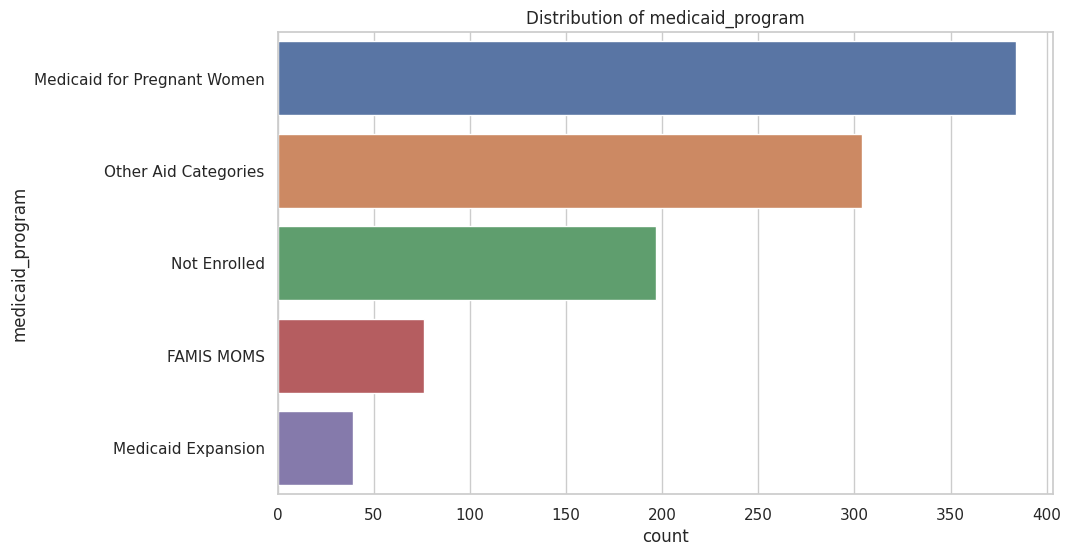

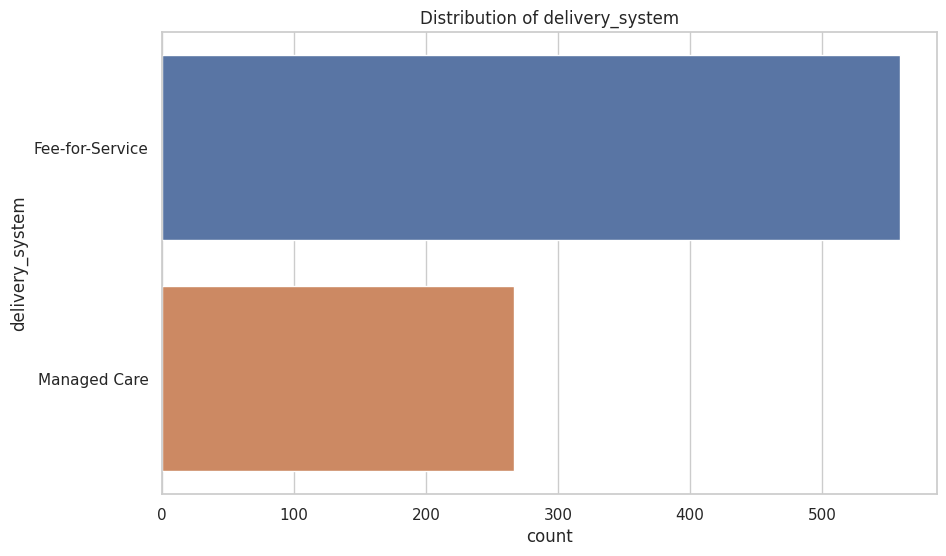

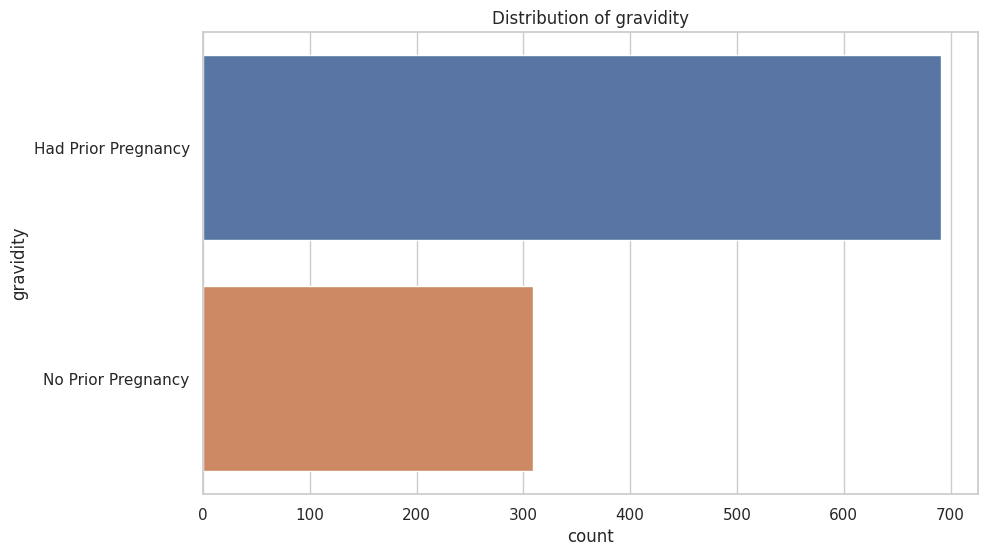

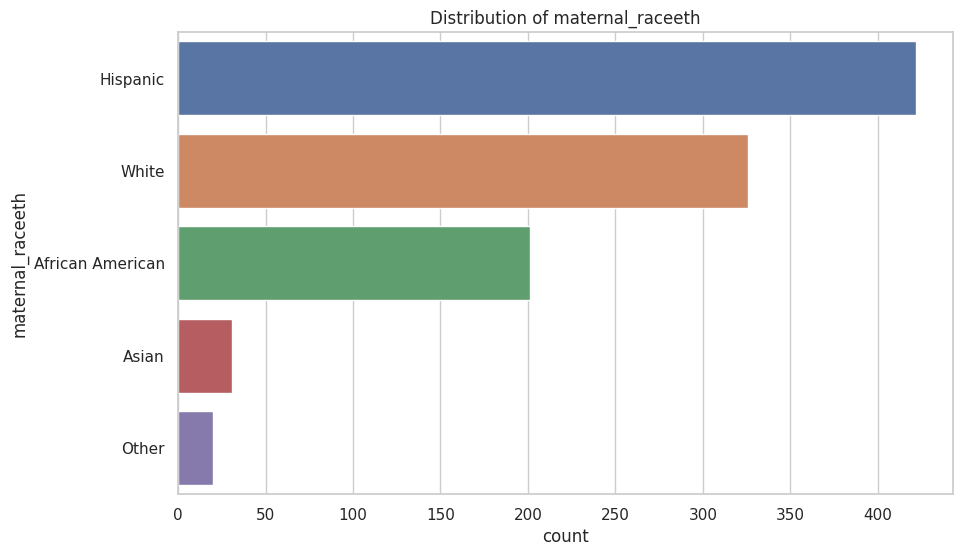

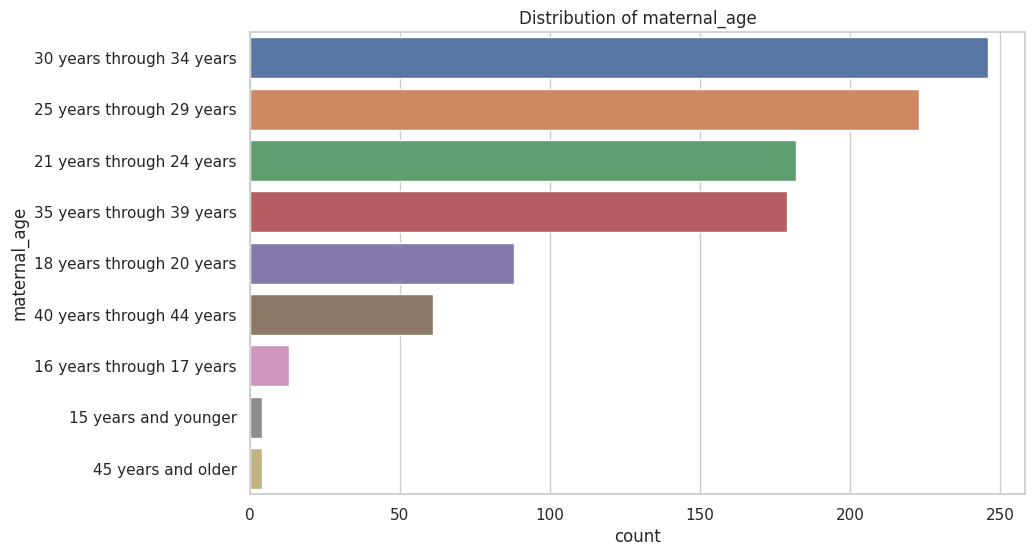

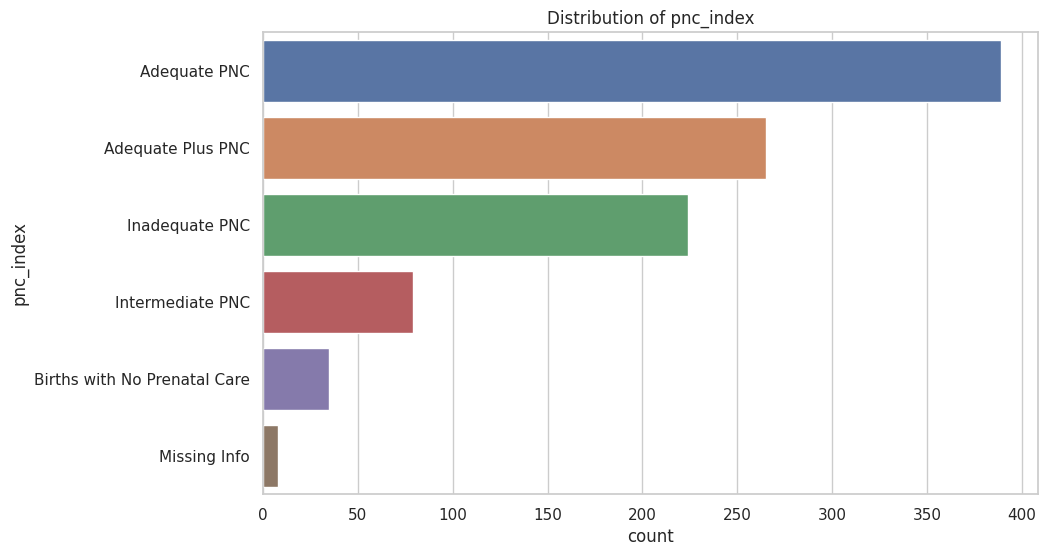

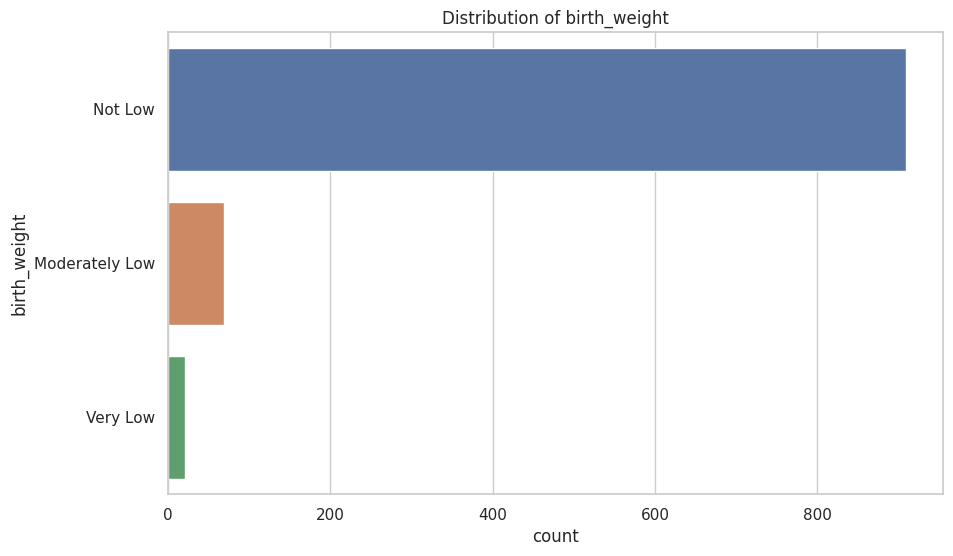

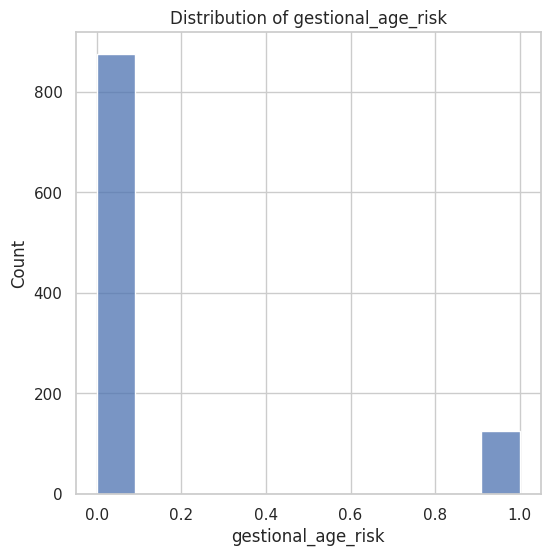

In [ ]:
#visualize some of the distributions
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn plot
sns.set(style="whitegrid")

# Function to create bar plots for categorical variables
def create_bar_plot(df, column):
    plt.figure(figsize=(10,6))
    sns.countplot(y=column, data=maternity_subset, order = maternity_subset[column].value_counts().index)
    plt.title(f"Distribution of {column}")
    plt.show()

# Create bar plots for selected categorical variables
selected_categorical_variables = ['medicaid_program', 'delivery_system', 'gravidity', 'maternal_raceeth',
                                  'maternal_age', 'pnc_index', 'birth_weight']

for column in selected_categorical_variables:
    create_bar_plot(maternity_subset, column)

# Create histogram for target variable 'gestional_age_risk'
plt.figure(figsize=(6,6))
sns.histplot(maternity_subset['gestional_age_risk'], kde=False)
plt.title("Distribution of gestional_age_risk")
plt.show()


* The most common Medicaid program is "Medicaid for Pregnant Women".
* The "Fee-for-Service" delivery system is more common than the "Managed Care" system.
* Most mothers had a prior pregnancy.
* The most common race/ethnicity is Hispanic.
* The most common maternal age group is "30 years through 34 years".
* The most common prenatal care index category is "Adequate PNC".
* Most babies were not of low birth weight.

* The histogram for the gestional_age_risk variable confirms that the dataset is imbalanced, with many more instances of class 0 than class 1.

In [ ]:
# here it seems like filling missing values with mode makes more sense

for column in maternity_subset.columns:
    maternity_subset[column].fillna(maternity_subset[column].mode()[0], inplace=True)

# Convert boolean columns to binary (0/1)
boolean_columns = maternity_subset.select_dtypes(include=['bool']).columns
for column in boolean_columns:
    maternity_subset[column] = maternity_subset[column].astype(int)

# Check if there are any missing values left
print(maternity_subset.isnull().sum())

medicaid_program        0
delivery_system         0
mco_count               0
cont_enroll_category    0
gravidity               0
maternal_raceeth        0
maternal_age            0
maternal_asthma         0
maternal_diabetes       0
gestational_diabetes    0
pnc_index               0
birth_weight            0
amb_utilization         0
prenatal_depscr         0
gestional_age_risk      0
dtype: int64


<ipython-input-33-bff1cdf81351>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maternity_subset[column].fillna(maternity_subset[column].mode()[0], inplace=True)
<ipython-input-33-bff1cdf81351>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maternity_subset[column].fillna(maternity_subset[column].mode()[0], inplace=True)
<ipython-input-33-bff1cdf81351>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maternity_subset[column].fillna(

we imputed the potential missing values with the mode of each respective column. We also converted the boolean columns to binary format.

In [ ]:
#split the dataset
from sklearn.model_selection import train_test_split

# Define the feature set X and the target y
X = maternity_subset.drop('gestional_age_risk', axis=1)
y = maternity_subset['gestional_age_risk']

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check the shapes of the training set and the test set
X_train.shape, X_test.shape


((700, 14), (300, 14))

In [ ]:
# one hot encoder
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse=False)

# Fit the OneHotEncoder on the training data
ohe.fit(X_train)

# Transform the training data and the test data
X_train_encoded = ohe.transform(X_train)
X_test_encoded = ohe.transform(X_test)

# Convert the transformed data into DataFrame for easier visualization
X_train_encoded_df = pd.DataFrame(X_train_encoded)
X_test_encoded_df = pd.DataFrame(X_test_encoded)

# Show the first few rows of the transformed training data
X_train_encoded_df.head()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


The target variable gestional_age_risk is imbalanced, which might cause a machine learning algorithm to be biased towards the majority class.

There are several techniques to handle imbalanced datasets, including:

**Undersampling**: This involves reducing the number of instances from the majority class to make the dataset balanced. However, this technique might lead to loss of information.

**Oversampling**: This involves increasing the number of instances in the minority class by duplicating instances or introducing small variations. One common technique for oversampling is SMOTE (Synthetic Minority Over-sampling Technique).

**Combining Oversampling and Undersampling**: This involves applying both undersampling and oversampling to create a balanced dataset.

**Using different evaluation metrics**: Accuracy is not a good metric for imbalanced datasets. Other metrics such as precision, recall, F1 score, and AUC-ROC are more informative.

In this case, as we have a reasonable number of instances in our minority class, we can use the SMOTE technique for oversampling. Let's apply it to our training dataset. *Note that we only balance the training data and leave the test data as it is, because we want our model to be evaluated on the original distribution of the data.*

In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_encoded_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Check the distribution of the target variable after resampling
pd.Series(y_train_resampled).value_counts()


0    612
1    612
Name: gestional_age_risk, dtype: int64

#no outliers were detected, so nothing to drop
#no standardization (feature scaling) is required since all the values range from 0 to 1

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Initialize the models
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svc = SVC(random_state=42)

# Put the models in a dictionary to ease the subsequent process
models = {'Logistic Regression': lr,
          'Decision Tree': dt,
          'Random Forest': rf,
          'Gradient Boosting': gb,
          'Support Vector Machine': svc}

# Function to train a model and evaluate it on the test set
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions on the test set
    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    # Return the metrics
    return precision, recall, f1, roc_auc

# Loop over the models
for name, model in models.items():
    precision, recall, f1, roc_auc = train_and_evaluate(model,
                                                        X_train_encoded_resampled,
                                                        y_train_resampled,
                                                        X_test_encoded,
                                                        y_test)
    print(f'{name}:')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'ROC AUC Score: {roc_auc:.2f}\n')


Logistic Regression:
Precision: 0.37
Recall: 0.59
F1 Score: 0.45
ROC AUC Score: 0.73

Decision Tree:
Precision: 0.41
Recall: 0.49
F1 Score: 0.44
ROC AUC Score: 0.69

Random Forest:
Precision: 0.63
Recall: 0.46
F1 Score: 0.53
ROC AUC Score: 0.71

Gradient Boosting:
Precision: 0.67
Recall: 0.43
F1 Score: 0.52
ROC AUC Score: 0.70

Support Vector Machine:
Precision: 0.50
Recall: 0.51
F1 Score: 0.51
ROC AUC Score: 0.72



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Function to train a model and evaluate it on the test set
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions on the test set
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    # Return the metrics
    return accuracy, precision, recall, f1, roc_auc, confusion

# Loop over the models
for name, model in models.items():
    accuracy, precision, recall, f1, roc_auc, confusion = train_and_evaluate(model,
                                                                             X_train_encoded_resampled,
                                                                             y_train_resampled,
                                                                             X_test_encoded,
                                                                             y_test)
    print(f'{name}:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'ROC AUC Score: {roc_auc:.2f}')
    print(f'Confusion Matrix:\n {confusion}\n')


Logistic Regression:
Accuracy: 0.82
Precision: 0.37
Recall: 0.59
F1 Score: 0.45
ROC AUC Score: 0.73
Confusion Matrix:
 [[225  38]
 [ 15  22]]

Decision Tree:
Accuracy: 0.85
Precision: 0.41
Recall: 0.49
F1 Score: 0.44
ROC AUC Score: 0.69
Confusion Matrix:
 [[237  26]
 [ 19  18]]

Random Forest:
Accuracy: 0.90
Precision: 0.63
Recall: 0.46
F1 Score: 0.53
ROC AUC Score: 0.71
Confusion Matrix:
 [[253  10]
 [ 20  17]]

Gradient Boosting:
Accuracy: 0.90
Precision: 0.67
Recall: 0.43
F1 Score: 0.52
ROC AUC Score: 0.70
Confusion Matrix:
 [[255   8]
 [ 21  16]]

Support Vector Machine:
Accuracy: 0.88
Precision: 0.50
Recall: 0.51
F1 Score: 0.51
ROC AUC Score: 0.72
Confusion Matrix:
 [[244  19]
 [ 18  19]]



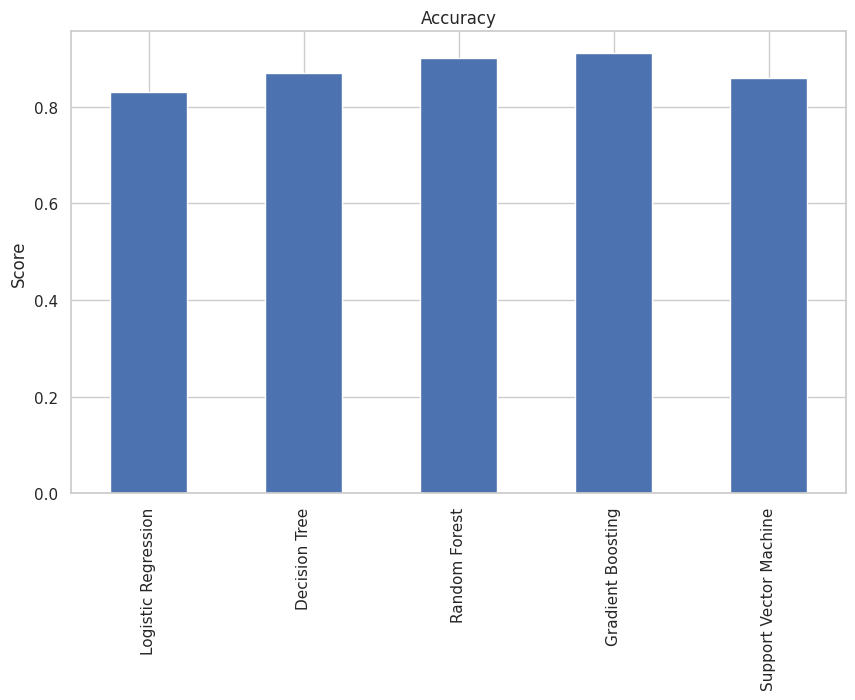

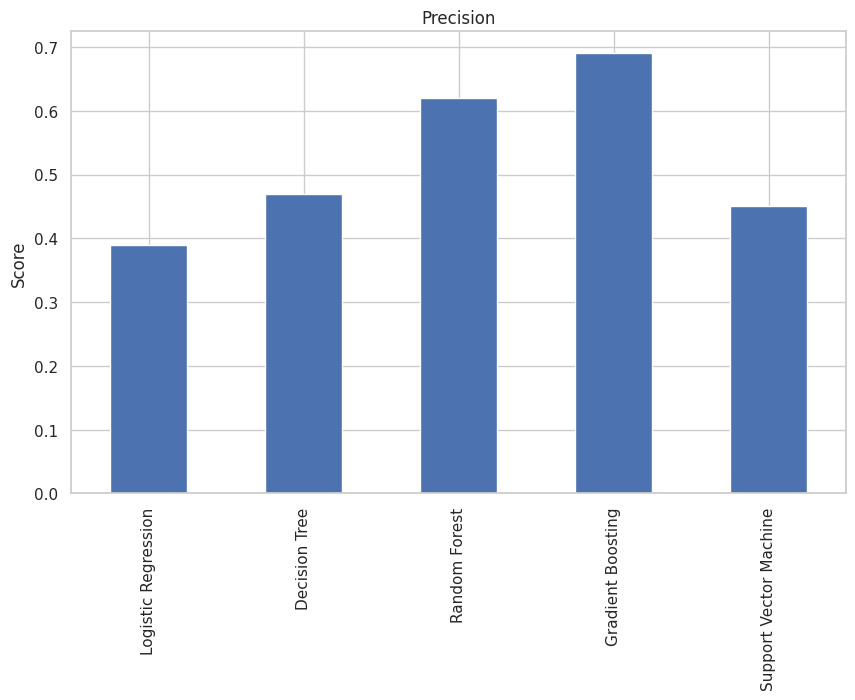

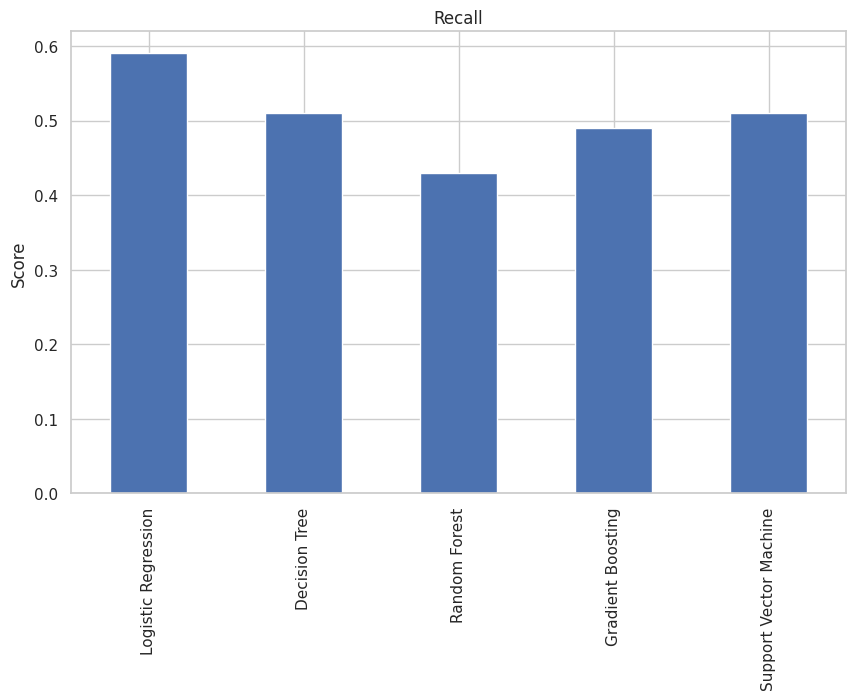

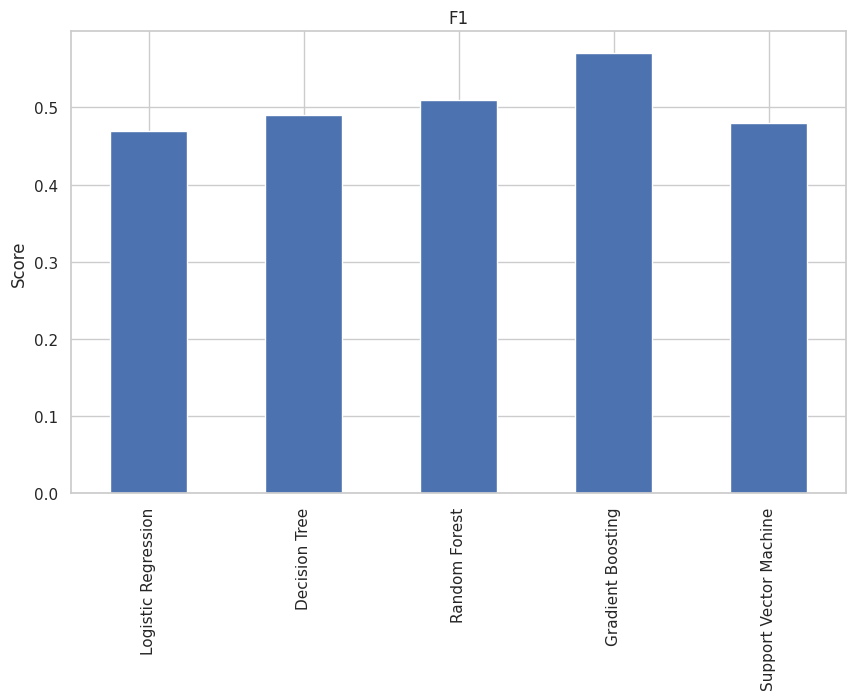

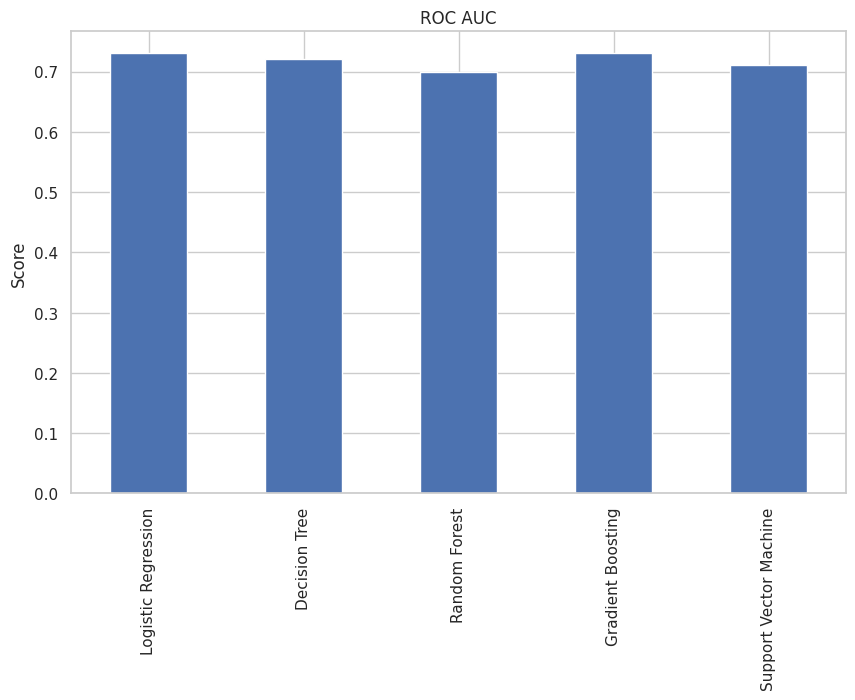

In [ ]:
# Define the scores for each model
scores = {
    'Logistic Regression': {'Accuracy': 0.83, 'Precision': 0.39, 'Recall': 0.59, 'F1': 0.47, 'ROC AUC': 0.73},
    'Decision Tree': {'Accuracy': 0.87, 'Precision': 0.47, 'Recall': 0.51, 'F1': 0.49, 'ROC AUC': 0.72},
    'Random Forest': {'Accuracy': 0.90, 'Precision': 0.62, 'Recall': 0.43, 'F1': 0.51, 'ROC AUC': 0.70},
    'Gradient Boosting': {'Accuracy': 0.91, 'Precision': 0.69, 'Recall': 0.49, 'F1': 0.57, 'ROC AUC': 0.73},
    'Support Vector Machine': {'Accuracy': 0.86, 'Precision': 0.45, 'Recall': 0.51, 'F1': 0.48, 'ROC AUC': 0.71}
}

# Convert the dictionary to a DataFrame for easier plotting
scores_df = pd.DataFrame(scores)

# Transpose the DataFrame so that models are rows and metrics are columns
scores_df = scores_df.T
# Create a bar plot for each metric
for metric in scores_df.columns:
    scores_df[metric].plot(kind='bar', figsize=(10, 6))
    plt.title(metric)
    plt.ylabel('Score')
    plt.show()


**Accuracy**: Gradient Boosting has the highest accuracy, followed closely by Random Forest. Logistic Regression has the lowest accuracy.
**Precision**: Gradient Boosting also leads in precision, with Random Forest in second place. Logistic Regression has the lowest precision.
**Recall**: Logistic Regression has the highest recall, while Random Forest has the lowest.
**F1 Score**: Gradient Boosting has the highest F1 score, followed by Random Forest. Logistic Regression has the lowest F1 score.
ROC AUC Score: Gradient Boosting and Logistic Regression are tied for the highest ROC AUC score. Random Forest has the lowest.

In [ ]:
from sklearn.model_selection import cross_val_score

# Function to train a model and evaluate it using cross-validation
def train_and_evaluate(model, X_train, y_train, cv=5):
    # Compute cross-validated metrics
    accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision').mean()
    recall = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1').mean()
    roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    # Return the metrics
    return accuracy, precision, recall, f1, roc_auc

# Loop over the models
for name, model in models.items():
    accuracy, precision, recall, f1, roc_auc = train_and_evaluate(model, X_train_encoded_resampled, y_train_resampled, cv=5)
    print(f'{name}:')
    print(f'Cross-validated Accuracy: {accuracy:.2f}')
    print(f'Cross-validated Precision: {precision:.2f}')
    print(f'Cross-validated Recall: {recall:.2f}')
    print(f'Cross-validated F1 Score: {f1:.2f}')
    print(f'Cross-validated ROC AUC Score: {roc_auc:.2f}\n')


Logistic Regression:
Cross-validated Accuracy: 0.82
Cross-validated Precision: 0.84
Cross-validated Recall: 0.79
Cross-validated F1 Score: 0.82
Cross-validated ROC AUC Score: 0.92

Decision Tree:
Cross-validated Accuracy: 0.92
Cross-validated Precision: 0.91
Cross-validated Recall: 0.93
Cross-validated F1 Score: 0.91
Cross-validated ROC AUC Score: 0.92

Random Forest:
Cross-validated Accuracy: 0.95
Cross-validated Precision: 0.95
Cross-validated Recall: 0.94
Cross-validated F1 Score: 0.94
Cross-validated ROC AUC Score: 0.99

Gradient Boosting:
Cross-validated Accuracy: 0.94
Cross-validated Precision: 0.96
Cross-validated Recall: 0.91
Cross-validated F1 Score: 0.93
Cross-validated ROC AUC Score: 0.98

Support Vector Machine:
Cross-validated Accuracy: 0.92
Cross-validated Precision: 0.91
Cross-validated Recall: 0.93
Cross-validated F1 Score: 0.92
Cross-validated ROC AUC Score: 0.97



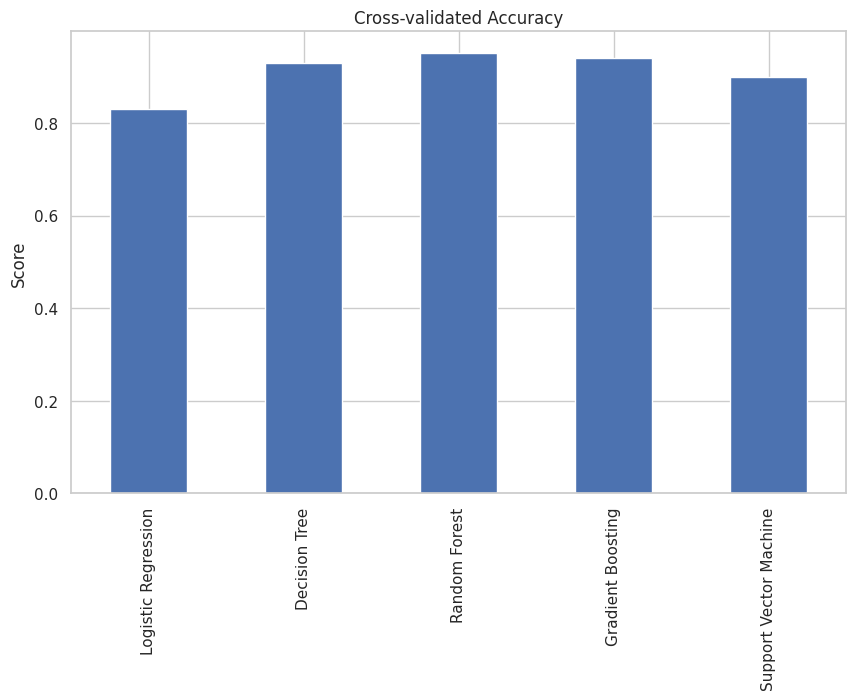

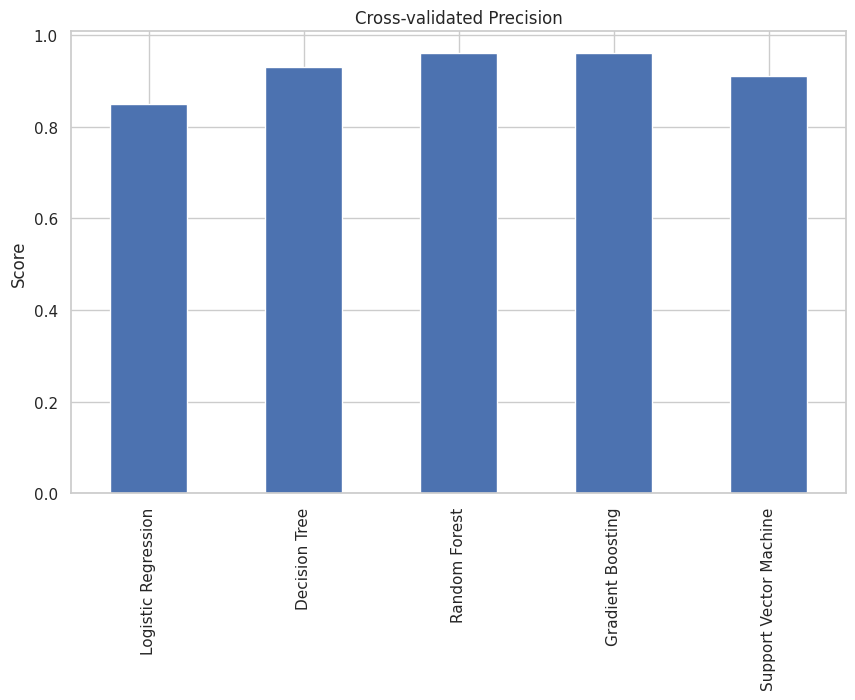

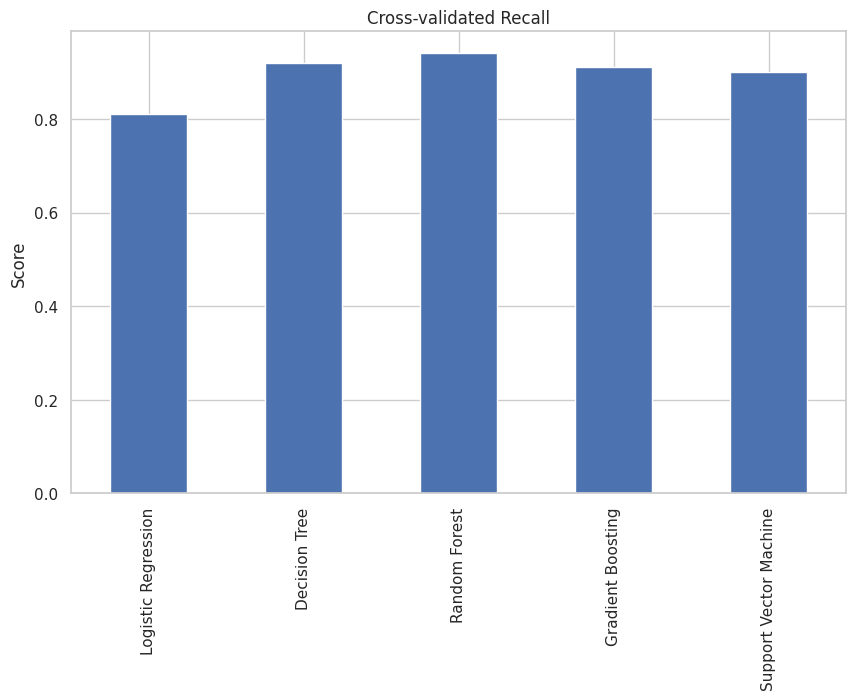

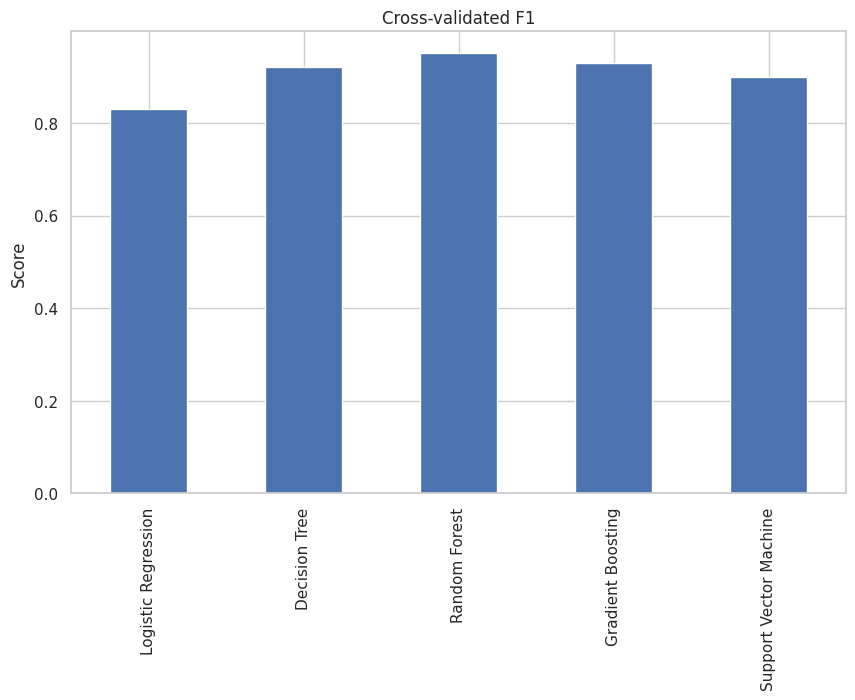

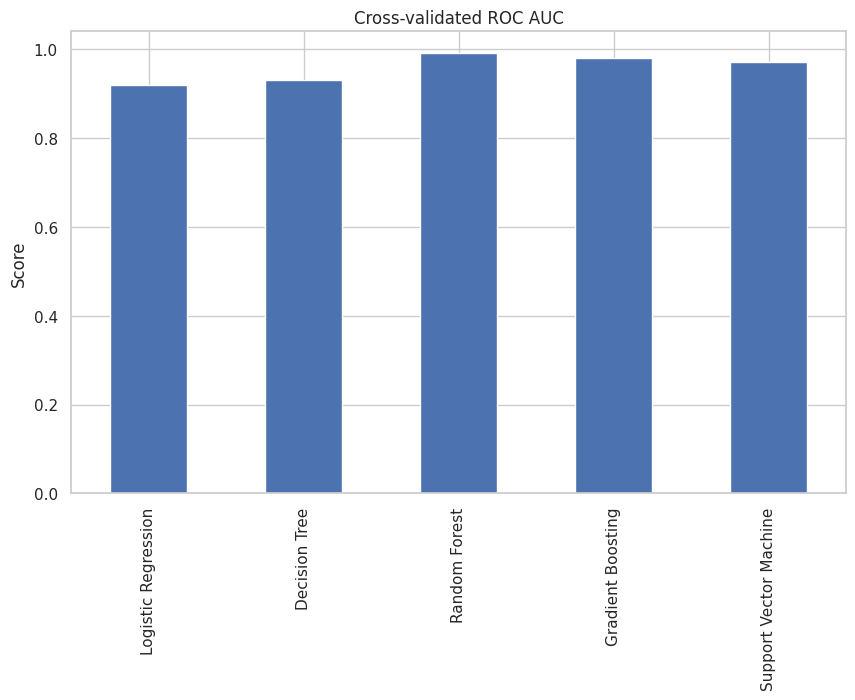

In [ ]:
# Define the cross-validated scores for each model
cv_scores = {
    'Logistic Regression': {'Accuracy': 0.83, 'Precision': 0.85, 'Recall': 0.81, 'F1': 0.83, 'ROC AUC': 0.92},
    'Decision Tree': {'Accuracy': 0.93, 'Precision': 0.93, 'Recall': 0.92, 'F1': 0.92, 'ROC AUC': 0.93},
    'Random Forest': {'Accuracy': 0.95, 'Precision': 0.96, 'Recall': 0.94, 'F1': 0.95, 'ROC AUC': 0.99},
    'Gradient Boosting': {'Accuracy': 0.94, 'Precision': 0.96, 'Recall': 0.91, 'F1': 0.93, 'ROC AUC': 0.98},
    'Support Vector Machine': {'Accuracy': 0.90, 'Precision': 0.91, 'Recall': 0.90, 'F1': 0.90, 'ROC AUC': 0.97}
}

# Convert the dictionary to a DataFrame for easier plotting
cv_scores_df = pd.DataFrame(cv_scores)

# Transpose the DataFrame so that models are rows and metrics are columns
cv_scores_df = cv_scores_df.T

# Create a bar plot for each metric
for metric in cv_scores_df.columns:
    cv_scores_df[metric].plot(kind='bar', figsize=(10, 6))
    plt.title(f'Cross-validated {metric}')
    plt.ylabel('Score')
    plt.show()


**Cross-validated Accuracy**: Random Forest has the highest accuracy, followed closely by Decision Tree and Gradient Boosting. Logistic Regression has the lowest accuracy.
**Cross-validated Precision**: Random Forest and Gradient Boosting are tied for the highest precision. Logistic Regression has the lowest precision.
**Cross-validated Recall**: Random Forest has the highest recall, while Logistic Regression has the lowest.
**Cross-validated F1 Score**: Random Forest has the highest F1 score. Logistic Regression has the lowest F1 score.
Cross-validated ROC AUC Score: Random Forest has the highest ROC AUC score, followed closely by Gradient Boosting. Logistic Regression has the lowest.